--------------------------------------------------------------------
ER background from materials. 
----------------------------------------------------------------
notebook can be run on the Freiburg cluster or on Dali. 
Change the path of files accordingly.
on dali files are on: /dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles

In [5]:
print("loading....")
%run 'init.ipynb'
%run 'geometry_checks_en.ipynb'
%run 'high_en_functions.ipynb'
print("done!")
from scipy.optimize import curve_fit
components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",#includes also pfte frame (Lxe + Gxe part)
             "SS_AnodeRing", #anode + all the electrodes 
             "Teflon_TPC_Sliding", #material is Teflon_TPC used twice for sliding and fixed
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             "Copper_TopRing", #includes also bottom ring
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate" #includes also top ring
             ]

import math
import scipy 
from scipy.special import beta

loading....
server chosen is: /userdata/arocchetti/rootfiles/
done!


In [6]:
def get_xyz(rootfile):
    dataframe = []
    for df in read_root(rootfile, "events/events", chunksize=1000000,
                             columns= ["xpri", "ypri", "zpri", "epri", "ns", "X", "Y", "Z", "Ed"],
                             where=("ns==1 & Ed > 2000 & Ed < 3000") ,
                            ):#, unit = "chunks"):
        #print(df.X)
        x_values=[x[0] for x in df.X]
        y_values=[y[0] for y in df.Y]
        z_values=[z[0] for z in df.Z]
        Ed_values = [Ed[0] for Ed in df.Ed]
        df["X"]=x_values
        df["Y"]=y_values
        df["Z"]=z_values
        df["Ed"]=Ed_values
        dataframe.append(df)
        if (len(dataframe)>0):
            dataframe=pd.concat(dataframe)
            dataframe.columns = ['xp', 'yp', 'zp_uc', "epri", "ns", "X", "Y", "Z_uc", "Ed"] #rename 
            offset = 1488/2
            dataframe['rp'] = np.sqrt(dataframe.xp**2+ dataframe.yp**2)
            dataframe['r2p'] = dataframe.rp*dataframe.rp
            dataframe['R'] = np.sqrt(dataframe.X**2+ dataframe.Y**2)
            dataframe['R2'] = (dataframe.R*dataframe.R)
            dataframe['Z'] = dataframe.Z_uc+offset
            dataframe['zp'] = dataframe.zp_uc+ offset

        break
        
    return dataframe

In [136]:
def load_data_and_normalize(param):
    if param == 1:
        df_ = pd.DataFrame()
        conv = 3.154e+7 #number of seconds in a year
        for component in components:
            print("working on:" , component)
            for i in range(0, len(isotope_array)):
                isotope = isotope_array[i]
                data, frac, material = get_data(isotope, component) 
                if len(data)>0:
                    N_ = number_of_events(material)
                    N = N_[isotope]
                    b = select_typepri(isotope) #later on with the good function
                    n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor 
                    p = scale_activity(component, final_date)
                    mass = p['mass']
                    contamination = p[isotope] 
                    if contamination > 0:
                        contamination = p[isotope]/1000 
                        time = n / (mass * contamination)
                        time_weights = [(1/time)*conv]*len(data)
                        isotope_name = [isotope]*len(data)
                        component_name = [component]*len(data)
                        data["weights"] = time_weights 
                        data["isotope"] = isotope_name
                        data["component"] = component_name
                        df_ = pd.concat([data, df_])
                    else:          
                        print("no contamination for ", isotope)
                        continue

                else:
                    print("no data for", isotope, component)
                    continue
        
        #df_.to_pickle("normalized_dataframe.pkl")
        return df_
    else:
        print("reading pickle file")
        df_ = pd.read_pickle("normalized_dataframe.pkl")
        return df_

In [146]:
data = load_data_and_normalize(0)
#data.weights = data.weights/400

reading pickle file


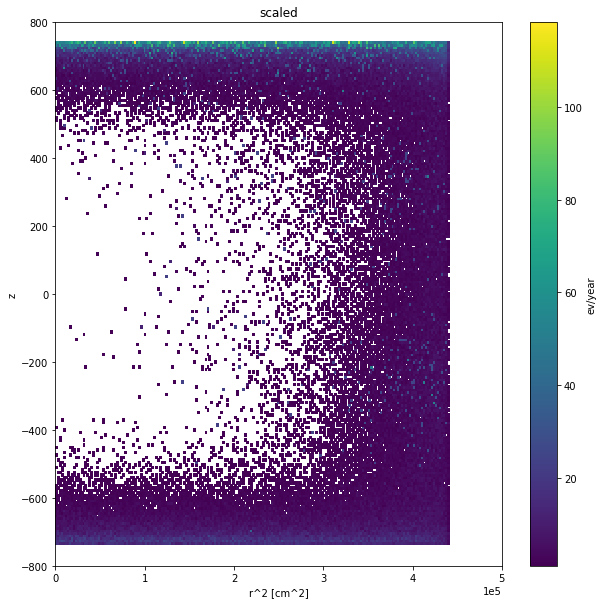

In [147]:
plt.figure(figsize = (10,10))
n=plt.hist2d(data.R2, data.Z, bins = (200,200), cmin = 1, 
             Norm = LogNorm, weights = data.weights)
h = plt.colorbar()
h.set_label("ev/year")
plt.title("scaled")
plt.ylabel("z")
plt.xlabel("r^2 [cm^2]")
plt.xlim(0,5e5)
plt.ylim(-800,800)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()


In [148]:
en_range = 400  #keV 2.2 MeV Bi214 and the 2.6 MeV

data = data[data.Ed > 2200]
data = data[data.Ed < 2600]

data.weights = data.weights

In [149]:
#copy so that if you screw up you don't have to reload the data
df = data.copy()

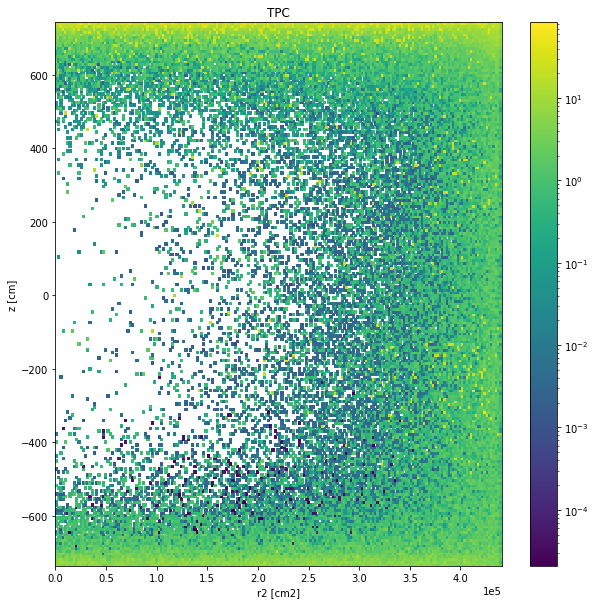

In [150]:
maxz = max(data.Z)
minz = min(data.Z)
def plot_param_space(data):
    plt.figure(figsize = (10,10))
    cmap = "viridis"
    plt.hist2d(data.R2, data.Z, bins=(200, 200),weights = data.weights, 
                 norm = LogNorm(),
              #cmin = 1
              )
    plt.colorbar()
    plt.xlim(0, max(df.R2))
    plt.ylim(minz, maxz)
    plt.xlabel("r2 [cm2]")
    plt.ylabel("z [cm]")
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.title("TPC")
    plt.show()
    
    
plot_param_space(data)

0.005297941465537319


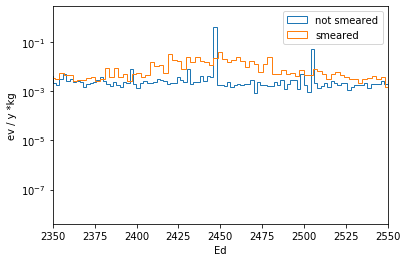

In [169]:
#let's have a look at the spectrum in energy given the 4t fv of low energy search  
Ed_sme = []
data["smearing_factor"] = 0.01 * data.Ed

data["Ed_sme"] = np.random.normal(data.Ed, data.smearing_factor)

def fv(data):
    data = data[data['R']<607.34]
    data = data[data.Z_uc < -106.0]
    data = data[data.Z_uc > -1315.0]
    return data

df_fv = fv(data)
print(sum(df_fv.weights)/(4000*400))
plt.hist(df_fv.Ed, weights = (df_fv.weights)/(4000) , bins = 200, 
         histtype = "step", label = "not smeared")
plt.hist(df_fv.Ed_sme, weights = (df_fv.weights)/(4000) , bins = 200,
         histtype = "step", label = "smeared")
plt.xlabel("Ed")
plt.yscale("log")
plt.xlim(2350, 2550)
plt.ylabel("ev / y * kg")
plt.legend()


background rate  0.004748125 ev/y*kg*keV


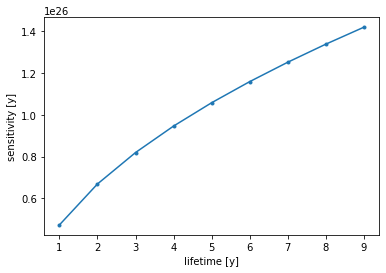

In [170]:
ia = 8.9/100
eps = 0.99
A = 2.25e-25
mass = 4000
dE = 2.35 * 0.01 * 2457.83
t = np.arange(1,10, 1)
b = 7597/(mass*400) #ev/kg*y
sensitivity = []
for i in t:
    square_root = np.sqrt(mass * i/(dE *b))
    sens = (eps * (ia / A)) * square_root 
    sensitivity.append(sens) 

plt.plot(t, sensitivity, ".-")
plt.xlabel("lifetime [y]")
plt.ylabel("sensitivity [y]")
print("background rate " , b, "ev/y*kg*keV")

In [152]:
# optimizing the fiducial volume
LXe_mass = 4000
def optimizing_FV(df, LXe_mass): 
    
    radius_steps = np.arange(1, 700, 50) 
    n_steps = np.arange(3, 12, 1) 
    shift_steps = np.arange(50, 200, 5) 
    
    result_1 = []
    result_2 = []
    
    for i in range(0, len(radius_steps)):
        
        for j in range(0,len(n_steps)):
            
            for k in range(0,len(shift_steps)):
                counts = []
                bkg = 0
                df_res = pd.DataFrame()
               
                height_half = (LXe_mass/2850)*10**9*2*n_steps[j] / (2/3*radius_steps[i]**2*4*math.pi*beta(2/n_steps[j], 1/n_steps[j])) 
              
                if height_half < 740: 
                    if (- shift_steps[k] + height_half <= 743.8) and (- shift_steps[k] - height_half >= -737):
                        
                        
                        df["fv"] = ((abs(df.R)/radius_steps[i])**n_steps[j] + (abs(df.Z+shift_steps[k])/height_half)**n_steps[j])
                       
                        df_res = df[df.fv <= 1] 
      
                        df_copy = df_res.copy()
                        bkg = sum(df_res.weights)
      
                        result_1.append(bkg)
                        result_2.append([radius_steps[i], n_steps[j], shift_steps[k], height_half])

    minimum = min(result_1)
    min_index = np.argmin(result_1)

    print(f"Background of the optimum: {result_1[min_index]} ev/year") 
    return result_2[min_index][0], result_2[min_index][1], result_2[min_index][2], result_2[min_index][3], LXe_mass, df_copy

In [153]:
radius, n_steps, shift, height , LXe_mass, df_copy = optimizing_FV(df, 4000)
print(radius, n_steps, shift, height , LXe_mass )

Background of the optimum: 7597.064031912952 ev/year
601 11 50 632.6442105217151 4000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


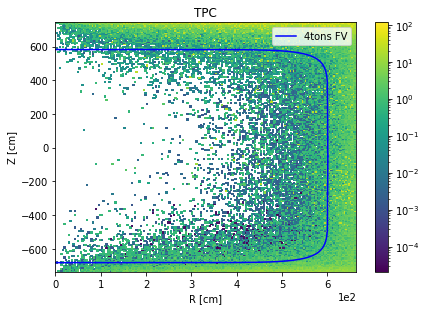

In [171]:
def SuperEllipse_up(x, radius, n_steps, shift, height):
    Z_res = []
    for i in x:
        Z = np.power(1 - ((abs(i)/radius)**n_steps), (1/n_steps))* height - shift 
        Z_res.append(Z)
    return Z_res
def SuperEllipse_down(x, radius, n_steps, shift, height):
    Z_res = []
    for i in x:
        Z = - np.power(1 - ((abs(i)/radius)**n_steps), (1/n_steps))* height - shift 
        Z_res.append(Z)
    return Z_res

x = np.arange(0,700,1)
Z_up = SuperEllipse_up(x, radius, n_steps, shift, height)
Z_down = SuperEllipse_down(x, radius, n_steps, shift, height)
plt.plot(x, Z_up, label = "4tons FV", color = "blue") 
plt.plot(x, Z_down, color = "blue")
plt.tight_layout()
plt.legend(loc = "best", fontsize = 10)
plt.xlabel("R [cm]")
plt.ylabel("Z [cm]")
cmap = "viridis"
plt.hist2d(data.R, data.Z, bins=(200, 200),weights = data.weights, 
                 norm = LogNorm())
plt.colorbar()
plt.xlim(0, max(df.R))
plt.ylim(minz, maxz)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title("TPC")
plt.show()

In [ ]:
def f(df,radius, n_steps, shift, height):
    df["fv"] = ((abs(df.R)/radius)**n_steps + (abs(df.Z+shift)/height)**n_steps)
    df = df[df.fv<1]
    return df

In [ ]:
df_show = f(data, radius, n_steps, shift, height)
plt.scatter(df_show.R, df_show.Z)
plt.show()

In [9]:
from multiprocessing import Pool
from multiprocessing import Process, Value, Array

In [67]:
# optimizing the fiducial volume

def optimizing_FV(LXe_mass): # array of r**2 (not r as it says), z, weights and LXe_mass in kg
    #print("working on mass:", LXe_mass)
    radius_steps = np.arange(1, 700, 10) 
    n_steps = np.arange(3, 12, 1) 
    shift_steps = np.arange(50, 200, 5) 
    
    result_1 = []
    result_2 = []
    
    for i in range(0, len(radius_steps)):
        for j in range(0,len(n_steps)):
            for k in range(0,len(shift_steps)):
                counts = []
                bkg = 0
                df_res = pd.DataFrame()
                height_half = (LXe_mass/2850)*10**9*2*n_steps[j] / (2/3*radius_steps[i]**2*4*math.pi*beta(2/n_steps[j], 1/n_steps[j])) 
                if height_half < 740: 
                    if (- shift_steps[k] + height_half <= 743.8) and (- shift_steps[k] - height_half >= -737):
                        df["fv"] = ((abs(df.R)/radius_steps[i])**n_steps[j] + (abs(df.Z+shift_steps[k])/height_half)**n_steps[j])
                        df_res = df[df.fv <= 1] 
                        bkg = sum(df_res.weights)
                        result_1.append(bkg)
                        result_2.append([radius_steps[i], n_steps[j], shift_steps[k], height_half])

    minimum = min(result_1)
    min_index = np.argmin(result_1)
    print(f"[ {LXe_mass}, {result_1[min_index]}],") 
    return result_2[min_index]

In [73]:
if __name__ == '__main__':
    p = Pool()
    res = p.map(optimizing_FV, [500, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
       1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
       1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
       1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
       1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540,
       1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650,
       1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760,
       1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870,
       1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980,
       1990, 2500, 3000, 4000, 4500, 5000])
print(res)

[ 1280, 0.88456015873769],
[ 1240, 0.7895364565522188],
[ 1300, 0.9409100261827195],
[ 1150, 0.6526897098840146],
[ 1250, 0.807364224438725],
[ 1270, 0.8488942010525541],
[ 1220, 0.7578037097644778],
[ 1120, 0.5940992399963871],
[ 1290, 0.9211798640780678],
[ 1200, 0.7340075153354229],
[ 1160, 0.6815832122705607],
[ 1140, 0.6240218826669653],
[ 1230, 0.7739516274963293],
[ 1170, 0.6991196012194454],
[ 1080, 0.54281321548051],
[ 1210, 0.7445264662384612],
[ 1130, 0.6060179536389273],
[ 1070, 0.5225279312638741],
[ 1190, 0.7249739776315309],
[ 1260, 0.8327558869763213],
[ 1000, 0.4486641668240868],
[ 1100, 0.5639147730061539],
[ 1020, 0.46591889314457585],
[ 1040, 0.49371396476714585],
[ 1180, 0.7142051645822948],
[ 1110, 0.5732721744571322],
[ 1090, 0.551125818352886],
[ 1010, 0.457356758132329],
[ 1060, 0.5131831166457966],
[ 1050, 0.5014415455552873],
[ 1030, 0.4850953684177667],
[ 500, 0.0724713357052299],
[ 1360, 1.036810305865613],
[ 1330, 0.9853079237387542],
[ 1520, 1.35202643151

Process ForkPoolWorker-188:
Process ForkPoolWorker-186:
Process ForkPoolWorker-183:
Process ForkPoolWorker-168:
Process ForkPoolWorker-179:
Process ForkPoolWorker-171:
Process ForkPoolWorker-170:
Process ForkPoolWorker-169:
Process ForkPoolWorker-165:
Process ForkPoolWorker-174:
Process ForkPoolWorker-184:
Process ForkPoolWorker-173:
Process ForkPoolWorker-161:
Process ForkPoolWorker-177:
Process ForkPoolWorker-175:
Process ForkPoolWorker-180:
Process ForkPoolWorker-189:
Process ForkPoolWorker-192:
Process ForkPoolWorker-185:
Process ForkPoolWorker-182:
Process ForkPoolWorker-191:
Process ForkPoolWorker-166:
Process ForkPoolWorker-162:
Process ForkPoolWorker-163:
Process ForkPoolWorker-187:
Process ForkPoolWorker-181:
Process ForkPoolWorker-190:
Process ForkPoolWorker-176:
Process ForkPoolWorker-178:
Process ForkPoolWorker-172:
Process ForkPoolWorker-164:
Process ForkPoolWorker-167:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/mul

  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


In [172]:
points_plot = [
[ 1280, 0.88456015873769],
[ 1240, 0.7895364565522188],
[ 1300, 0.9409100261827195],
[ 1150, 0.6526897098840146],
[ 1250, 0.807364224438725],
[ 1270, 0.8488942010525541],
[ 1220, 0.7578037097644778],
[ 1120, 0.5940992399963871],
[ 1290, 0.9211798640780678],
[ 1200, 0.7340075153354229],
[ 1160, 0.6815832122705607],
[ 1140, 0.6240218826669653],
[ 1230, 0.7739516274963293],
[ 1170, 0.6991196012194454],
[ 1080, 0.54281321548051],
[ 1210, 0.7445264662384612],
[ 1130, 0.6060179536389273],
[ 1070, 0.5225279312638741],
[ 1190, 0.7249739776315309],
[ 1260, 0.8327558869763213],
[ 1000, 0.4486641668240868],
[ 1100, 0.5639147730061539],
[ 1020, 0.46591889314457585],
[ 1040, 0.49371396476714585],
[ 1180, 0.7142051645822948],
[ 1110, 0.5732721744571322],
[ 1090, 0.551125818352886],
[ 1010, 0.457356758132329],
[ 1060, 0.5131831166457966],
[ 1050, 0.5014415455552873],
[ 1030, 0.4850953684177667],
[ 500, 0.0724713357052299],
[ 1360, 1.036810305865613],
[ 1330, 0.9853079237387542],
[ 1520, 1.352026431511413],
[ 1350, 1.0147831852826936],
[ 1320, 0.9660839183093708],
[ 1560, 1.4510539697266918],
[ 1450, 1.1934948583564575],
[ 1340, 1.0009573418037958],
[ 1400, 1.1209733984126762],
[ 1540, 1.3955878192840012],
[ 1470, 1.2314371448938168],
[ 1440, 1.1787654657397544],
[ 1570, 1.4731399996429735],
[ 1610, 1.5715687405044845],
[ 1310, 0.9563279393937552],
[ 1590, 1.5185137898274674],
[ 1370, 1.0567909284516845],
[ 1420, 1.15264908474667],
[ 1390, 1.1161697584605983],
[ 1380, 1.0927675026079922],
[ 1500, 1.315768249535664],
[ 1620, 1.587356788205587],
[ 1600, 1.5490505154947598],
[ 1410, 1.1374038958407495],
[ 1490, 1.2843626938310966],
[ 1460, 1.2117897490987277],
[ 1480, 1.26542096326218],
[ 1430, 1.168060895420835],
[ 1530, 1.3784068240767613],
[ 1550, 1.433040024570046],
[ 1510, 1.3312540360073888],
[ 1580, 1.4979649556754882],
[ 1650, 1.66854081250374],
[ 1750, 1.9781656803544023],
[ 1660, 1.716021591685343],
[ 1760, 2.0048177802036338],
[ 1640, 1.6449435541891404],
[ 1670, 1.745245789676997],
[ 1780, 2.0688518585372515],
[ 1790, 2.087966529007895],
[ 1690, 1.7995868854325336],
[ 1730, 1.917579431847216],
[ 1800, 2.1159975826877253],
[ 1700, 1.8286009775117908],
[ 5000, 38.458328260111315],
[ 1720, 1.8913816041660505],
[ 1740, 1.9395066355515458],
[ 1810, 2.1324321646058007],
[ 1770, 2.03202776174358],
[ 1910, 2.3489340092851645],
[ 1710, 1.8555660220706345],
[ 4500, 29.461682842946296],
[ 1870, 2.2507498925127263],
[ 1680, 1.7652898133770025],
[ 1630, 1.6235855082500505],
[ 4000, 18.75338139424707],
[ 1840, 2.1917280814104636],
[ 1900, 2.3274246149641535],
[ 1890, 2.2874147203985866],
[ 1820, 2.144329386333079],
[ 1830, 2.1763387931330853],
[ 1880, 2.2703131176105233],
[ 1850, 2.2080250368715824],
[ 1860, 2.2335396662214997],
[ 1920, 2.381546885550337],
[ 3000, 7.473951997218244],
[ 1930, 2.402005414631236],
[ 2500, 4.656169507420951],
[ 1940, 2.4509368965568767],
[ 1980, 2.5512386961538533],
[ 1950, 2.4706684850705107],
[ 1990, 2.5889775207751673],
[ 1970, 2.528231803506112],
[ 1960, 2.5070504136093756]
    
]
print(len(points_plot))

ellipses_param = [[301, 9, 60, 318.45785357320426], 
                  [371, 11, 80, 415.05024208748483],
                  [381, 4, 50, 444.55523475185925],
                  [381, 4, 50, 448.95677172960046],
                  [371, 7, 50, 439.9472178253575],
                  [371, 6, 50, 451.3855274751802],
                  [371, 7, 50, 448.48988224915075], [371, 7, 50, 452.7612144610475], [371, 7, 50, 457.0325466729441], [371, 10, 50, 450.2029197637526], [371, 11, 50, 452.40476387535847], [371, 11, 50, 456.5552662962333], [371, 11, 50, 460.70576871710807], [371, 11, 50, 464.85627113798296], [371, 9, 50, 473.74602030633383], [371, 10, 55, 475.21419308396105], [371, 8, 55, 485.88275173645354], [371, 9, 60, 486.3233482790683], [371, 6, 60, 507.8087184095777], [391, 8, 50, 448.8590167542843], [391, 7, 50, 457.61959956006797], [391, 11, 50, 448.4109630719068], [391, 11, 50, 452.14772109750606], [391, 9, 50, 460.4911269514822], [391, 9, 50, 464.2656443855107], [391, 9, 50, 468.0401618195392], [391, 8, 55, 475.4862465617418], [391, 9, 60, 475.5891966875963], [391, 9, 60, 479.3637141216249], [391, 9, 65, 483.1382315556534], [391, 8, 70, 490.7018064517176], [391, 7, 70, 499.9205709479734], [411, 8, 50, 450.99228561229637], [411, 8, 50, 454.4349748154437], [411, 7, 50, 462.8914588359655], [411, 6, 50, 473.8962422287472], [411, 6, 50, 477.4327813498573], [411, 6, 55, 480.9693204709674], [411, 6, 55, 484.50585959207746], [411, 6, 60, 488.0423987131874], [431, 6, 50, 447.015281775547], [431, 6, 50, 450.23121905450773], [431, 6, 50, 453.44715633346846], [431, 7, 50, 449.4123204054089], [431, 6, 50, 459.8790308913901], [431, 5, 50, 474.7991858992827], [431, 5, 50, 478.0964024680277], [431, 5, 55, 481.3936190367728], [441, 4, 50, 482.94142798630963], [431, 6, 65, 475.9587172861938], [431, 5, 60, 491.2852687430077], [431, 5, 65, 494.5824853117528], [431, 5, 65, 497.8797018804978], [441, 5, 55, 478.7055061833793], [441, 6, 65, 469.976737605143], [441, 6, 65, 473.0484809881831], [441, 4, 60, 509.2239546794421], [441, 4, 65, 512.5092705160837], [451, 5, 60, 472.76855464419066], [451, 5, 60, 475.77981932345295], [451, 5, 65, 478.79108400271537], [451, 5, 65, 481.80234868197766], [451, 4, 65, 505.7397603028889], [451, 4, 65, 508.8810010501118], [451, 5, 75, 490.8361427197648], [451, 4, 70, 515.1634825445577], [451, 5, 80, 496.8586720782896], [451, 8, 60, 474.6095421304926], [451, 5, 85, 502.8812014368142], [451, 11, 60, 471.85079239312813], [451, 10, 55, 476.7228753466401], [451, 11, 65, 477.4680637311417], [451, 8, 65, 488.9050102669531], [451, 11, 65, 483.0853350691551], [451, 9, 80, 490.8038602115386], [451, 9, 80, 493.64087674455317], [451, 11, 70, 491.5112420761753], [451, 9, 50, 499.3149098105826], [451, 11, 75, 497.1285134141887], [451, 11, 55, 499.93714908319544], [451, 8, 60, 511.77775928529013], [501, 3, 50, 496.7817096861779], [501, 3, 50, 499.54160807332346], [501, 3, 50, 502.30150646046883], [501, 4, 65, 465.8326707397079], [501, 3, 55, 507.82130323475974], [501, 3, 55, 510.5812016219053], [501, 3, 60, 513.3411000090507], [501, 3, 60, 516.100998396196], [501, 3, 65, 518.8608967833416], [501, 3, 65, 521.6207951704869], [501, 3, 70, 524.3806935576324], [501, 3, 70, 527.1405919447777], [501, 4, 85, 488.7424742187099], [501, 4, 85, 491.28800793859904], [511, 3, 70, 514.6695496874892], [511, 3, 70, 517.3224855106205], [501, 4, 70, 498.9246090982664], [501, 4, 70, 501.4701428181555], [501, 5, 85, 483.16086753150546], [501, 4, 75, 506.5612102579337], [531, 11, 85, 506.523334531757], [551, 8, 50, 574.6448492114768], [611, 11, 50, 612.1051895946223], [631, 11, 50, 645.6576276185658], [691, 11, 50, 598.2220273808119]]

masses = []
rates = []
param = []
for i in points_plot:
    masses.append(i[0])
    rates.append(i[1]/(i[0]*400)) #ev/kg*y*keV

for i in ellipses_param:
    param.append(i)


106


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


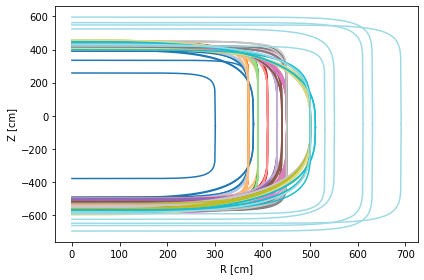

In [83]:
colors = ["b", "g", "r", "c", "m", "y", "b", "w", "b", "g", "r"]
def SuperEllipse_up(x, radius, n_steps, shift, height):
    Z_res = []
    for i in x:
        Z = np.power(1 - ((abs(i)/radius)**n_steps), (1/n_steps))* height - shift 
        Z_res.append(Z)
    return Z_res
def SuperEllipse_down(x, radius, n_steps, shift, height):
    Z_res = []
    for i in x:
        Z = - np.power(1 - ((abs(i)/radius)**n_steps), (1/n_steps))* height - shift 
        Z_res.append(Z)
    return Z_res

x = np.arange(0,700,1)
#fig= plt.figure(figsize=(20,16))

for i in range(0, len(param)):    
    radius = param[i][0]
    n_steps =  param[i][1]
    shift = param[i][2]
    height = param[i][3]
    Z_up = SuperEllipse_up(x, radius, n_steps, shift, height)
    Z_down = SuperEllipse_down(x, radius, n_steps, shift, height)
    label = f"mass:{masses[i]/1000} t"
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, len(masses))]
    plt.plot(x,Z_up, color=colors[i], label = label
            ) 
    plt.plot(x,Z_down, color=colors[i],
            )
    plt.tight_layout()
    #plt.legend(markerscale = 10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
    #           fontsize = "medium", #bbox_to_anchor=(105, 100), 
    #          ) 
    #plt.legend(loc = "best", fontsize = 10)
    plt.xlabel("R [cm]")
    plt.ylabel("Z [cm]")
    



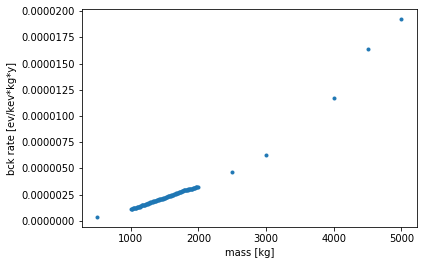

In [174]:
plt.plot(masses, rates, '.')
plt.xlabel("mass [kg]")
plt.ylabel("bck rate [ev/kev*kg*y]")
plt.show()

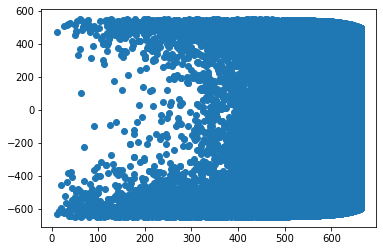

In [65]:
def f(df,radius, n_steps, shift, height):
    df["fv"] = ((abs(df.R)/radius)**n_steps + (abs(df.Z+shift)/height)**n_steps)
    df = df[df.fv<1]

    return df

In [ ]:
plt.hist2d(df_copy.R2, df_copy.Z, cmin = 1, bins = (200, 200))
plt.xlim(0, 500e3)
plt.ylim(minz, maxz)
plt.show()

print(sum(df_copy.weights))

In [55]:
#insert the other backgrounds 
back_Rn222 = 3.09e-4 * 400
back_136Xe = 5.78e-6 * 400
back_137Xe = 1.42e-3 * 400
back_8B = 1.36e-3 * 400

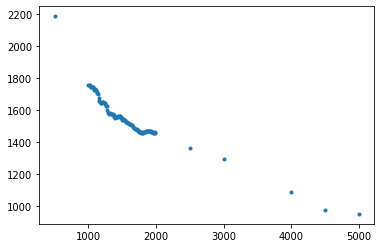

In [175]:
b = rates #ev/kg * keV * y
M_fv = masses
t = 5 #y
dE = 0.01 * 2457.83 * 2.35
sens = []
for i in range(0, len(masses)):
    B = rates[i] * dE * t * masses[i]
    sens_param = masses[i] / np.sqrt(B)
    sens.append(sens_param)
plt.plot(masses, sens,'.' )

In [56]:
#write the formula

eps = 0.9 #the detection efficiency of the 0vbb decay as a SS event
alpha = 0.089 #abundance of 136Xe
N_a = 6.02214076e23
M_xe = 131.293 #molar mass of Xe
#M fiducial mass in tons
#t measuring time in years
#B background index 
#f_ROI: the fraction of signal covered by the ROI (for us it was 0.76, we used the FWHM)
dE = 400
a = eps * f_roi * alpha * N_a
b = 1.64 * M_xe
c = np.sqrt(M*t)/ np.sqrt(B * dE)
T = np.log(2) * (a/b) * c

NameError: name 'f_roi' is not defined

# Old implementation

In [ ]:
r_min = min(df.R2)
r_max = max(df.R2)
z_min = min(df.Z)
z_max = max(df.Z)

n_bins_r2 = 10
n_bins_z = 10

r2 = np.linspace(r_min,r_max,n_bins_r2)

z_min = min(df.Z)
z_max = max(df.Z)
middle_1t = (-(z_max-z_min)/2)+z_max

z = np.linspace(z_min,z_max,n_bins_z)

R, Z = np.meshgrid(r2, z)
print(R.shape)

In [ ]:
plt.figure(figsize = (10,10))
cmap = "viridis"
plt.hist2d(df.R2, df.Z, bins=(100, 100),
           weights = df.weights,  norm = LogNorm())
plt.colorbar()
plt.xlim(0, 450e3)
plt.ylim(plt.ylim(minz, maxz))
plt.xlabel("r2 [cm2]")
plt.ylabel("z [cm]")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


for i in range(len(r2)):
    plt.axvline(x=r2[i], color='r', alpha=0.6, linestyle='--')
for i in range(len(z)):
    plt.axhline(y=z[i], color='r', alpha=0.6, linestyle='--')

plt.show()

In [ ]:
a = np.zeros((n_bins_z, n_bins_r2))
print(n_bins_z)
print(n_bins_r2)

In [ ]:
def figure_merit(z_low,z_high,r_low,r_high):
    m=1
    section = df[df.Z>z_low]
    section = section[section.Z<z_high]
    section = section[section.R2>r_low]
    section = section[section.R2<r_high]
    counts = (sum(section.weights)) #to know how many events in each section, I just need to sum the weigths as each event counts as 1*weights. 
    figure = m/np.sqrt(counts)
    #print(counts)
    return figure#, counts


In [ ]:
print(R)

In [ ]:
def calculate_fom():
    
    Figure = np.zeros((n_bins_z, n_bins_r2))
    print(Figure.shape)
    for i in range(0, n_bins_z-1):
        #print("-------------------------- i ", i)
        for j in range(0, n_bins_r2-1):
            #print("---------- j ", j)
            #print(Z[i][j],Z[i+1][j],R[i][j],R[i][j+1])
            figure = figure_merit(Z[i][j],Z[i+1][j],R[i][j],R[i][j+1])
            Figure[i][j] = figure
            
            #print(Figure)

    return Figure
Figure = calculate_fom()

In [ ]:
import pickle 
def calculate_fom(param, n_bins):
    if param == 1:
        print("calculating, be patient")
        Figure = np.zeros( (len(Z), len(R)) )
        Counts = np.zeros( (len(Z), len(R)) )
        for i in range(len(Z)-1):
            for j in range(len(R)-1):
                figure = figure_merit(Z[i][j],Z[i+1][j],R[i][j],R[i][j+1])
                Figure[i][j] = figure

        with open(f'Figure_{n_bins}.pkl','wb') as f:
            pickle.dump(Figure, f)
    else:
        print("reading the pickle")
        with open(f'Figure_{n_bins}.pkl','rb') as f:
            Figure = pickle.load(f)
    return Figure

In [ ]:
Figure = calculate_fom(1, n_bins)

In [ ]:
Figure = calculate_fom(1, n_bins)
x_axis_labels = []
y_axis_labels = []
for i in R[0]:
    x_axis_labels.append(str(i))

for i in range(0,len(Z)):
    lab = Z[i][0]
    y_axis_labels.append(str(lab))    

In [ ]:
#need to format the lables and to add a note that this is the sensitivity*10
import seaborn as sns
plt.figure(figsize = (10,10))
from matplotlib.ticker import FormatStrFormatter
ax = sns.heatmap(Figure*10, annot=True, fmt = ".3f", 
                annot_kws={"size": 10}, #xticklabels=x_axis_labels, yticklabels=y_axis_labels
               )

In [ ]:
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
matplotlib.rcParams.update({'font.size': 25}) 

#levels=[0.045,0.038,0.025, 0.010, 0.005,0.001, 0.0001]
levels = [ 0.12,0.10, 0.07, 0.05, 0.04, 0.03, 0.02, 0.015] #0.015]
levels = levels[::-1]

h = plt.contourf(R,Z,Figure, 100, cmap='RdBu_r') #filled contours
c = plt.contour(R,Z,Figure, levels, colors='k') #levels
plt.clabel(c, inline=True, fontsize=10, colors='k')
plt.xlabel('$R^2$ [$cm^2$]',fontsize=30)
plt.ylabel('$Z}$ [cm]',fontsize=30)
cbar = plt.colorbar(h, label='Figure of merit')
cbar.ax.tick_params(labelsize=15) 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.show()

In [ ]:
cont = c.allsegs #List of all the polygon segments for all the levels.
cont_r = []
cont_z = []

for j in range(len(cont)):

    r_column = []
    z_column = []
    
    for i in range(len(cont[j][0])):
        r_column.append(cont[j][0][i][0])
        z_column.append(cont[j][0][i][1])
        last_j = j
        last_i = i
    #else:
    #    r_column.append(cont[last_j][0][last_i][0])
    #    z_column.append(cont[last_j][0][last_i][1])
    
    cont_r.append(r_column)
    cont_z.append(z_column)

In [ ]:
df.columns

In [ ]:
for i in range(0, len(cont)):
    plt.plot(cont_r[i], cont_z[i], label = f"{i}")
    plt.scatter(cont_r[i], cont_z[i])
    plt.legend()
    #print(i, len(cont_r[i]))

In [ ]:
def ellipsoid(z,r,zmin,zmax,p):
    vz = np.abs((zmin - zmax)/2)
    z0 = zmax - vz
    return r * np.power( (1- (np.absolute(z-z0)/vz)**p) , 1/p) 

Ellipsoid with 4 free parameters:
- the minimum (or maximum) Z,
- the difference between maximum and minimum, 
- the maximum radius
- shape parameter.

In [ ]:
tpc_length = 1488
print(tpc_length)
def SuperEllipseUpperZs(x, zloc, zscale, r2scale, power_const):
    Zs = np.power(
        1. - np.power(
            x/r2scale,
            power_const
        ),
        1./power_const
    )*zscale+zloc
    line = -tpc_length
    #return np.maximum(Zs,line)
    return Zs

def SuperEllipseUpperZs_2(x, zloc, zscale, r2scale, power_const):
    Zs = np.power(
        1. - np.power(
            x/r2scale,
            power_const
        ),
        1./power_const
    )*zscale+zloc
    line = -tpc_length
    return np.maximum(Zs,line)


def SuperEllipseLowerZs(x, zloc, zscale, r2scale, power_const):
    Zs = -np.power(
        1. - np.power(
            x/r2scale,
            power_const
        ),
        1./power_const
    )*zscale+zloc
    line = -tpc_length
    return np.maximum(Zs, line)
    
#zloc, zscale, r2scale, power_const
popt_lowers = [0, 2000, 3365.00009977, 3]

popt_uppers = [0, 16.35006807, 3366.99766348, 3]

In [ ]:
from scipy.integrate import quad

def fit_ellipsoid(df, z, r2, func_up, func_low, t1, t2):
    tpc_length = (max(data.Z)- min(data.Z))
    z_min = min(z)
    z_max = max(z)
    z_diff = (z_max-z_min)
    r_2 = max(r2)
    idx = np.argmax(r2)
    
    z_min_fit = np.minimum(z_min, -tpc_length)
    
    plt.scatter(r2[:idx],z[:idx], color=col[i]) 
    plt.scatter(r2[idx:],z[idx:], color=col[i])
    init_up = [z_min_fit,z_diff,r_2,t1]
    init_low = [z_max,z_diff,r_2,t2]
    
    fitparup, fitcovup = curve_fit(func_up, r2[:idx+1], z[:idx+1], init_up, 4.8*np.ones(len(z[:idx+1])))
    fitparlow, fitcovlow = curve_fit(func_low, r2[idx:], z[idx:], init_low, 4.8*np.ones(len(z[idx:])))
  
    y_up = func_up(r2[:idx+1], *fitparup)
    y_down = func_low(r2[idx:], *fitparlow)
    
    plt.plot(r2[:idx+1], y_up)
    plt.plot(r2[idx:], y_down)
    
    # Integrals method
    I_low, err_low = quad(func_low, 0, r_2, args=(fitparlow[0],fitparlow[1],fitparlow[2],fitparlow[3]))
    I_up, err_up = quad(func_up, 0, r_2, args=(fitparup[0],fitparup[1],fitparup[2],fitparup[3]))
    volume_I = np.pi*(I_low-I_up)
    mass_I = (volume_I*rho_xenon)/1000
    #print('Integral method:')
    #print('Volume = ', volume_I,'cm^3 --> Mass = ', mass_I, 'kg')
   
    #we select the area in the ellipsoids
    df_in = df[df.Z < func_low(df.R2,fitparlow[0],fitparlow[1],fitparlow[2],fitparlow[3])]
    df_in = df_in[df_in.Z > func_up(df_in.R2,fitparup[0],fitparup[1],fitparup[2],fitparup[3])]
    
    bkg_counts = sum(df_in.weights)
    print('counts = ', bkg_counts, "mass", mass_I)
    
 
    Mass = mass_I
    figure_of_merit = np.sqrt(Mass/(bkg_counts*Mass))
    #print('Figure of merit =',figure_of_merit)
    #print('----------------------------------------------------')
    
    return fitparup, fitparlow, figure_of_merit, Mass

In [ ]:
rho_xenon = 2.862 #[g/cm3]
n_contour = len(cont_r)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 12)

col = ['r','k','b','g','orange','cyan','magenta','gold','purple','indigo']

n_contour = len(cont_r)

fom = []
mass = []

#for i in range(0, n_contour)[::-1]:
for i in range(3,4):
    p1=3
    p2=2
    par_up, par_low, figure_of_merit, Mass = fit_ellipsoid(df, cont_z[i], cont_r[i], 
                                                           SuperEllipseUpperZs, SuperEllipseLowerZs, p1,p2)

    fom.append(figure_of_merit)
    mass.append(Mass)

In [ ]:
plt.scatter(mass, fom)
plt.xlabel('Fiducial Mass [kg]')
plt.ylabel('FoM in the Volume')
print(len(mass))

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
matplotlib.rcParams.update({'font.size': 15}) 

mass = np.array(mass)
mass = mass/1000

plt.scatter(mass, fom)
plt.xlabel('Fiducial Mass [kg]')
plt.ylabel('FoM in the Volume [kg / sqrt(counts)]')

for i in range(len(mass)):
    plt.text(mass[i], fom[i]-0.035, '%5.3f' % levels[i],
             fontsize=12,rotation=0, color='k')
    print('contour fom:',levels[i], '--> Fiducial Mass =',mass[i])

plt.ylim([0, 1])
plt.show()

In [ ]:
#version with arrays 
r = df.R2
r = r.to_numpy()

z = ( df.Z)
z = z.to_numpy()

weights = df.weights
weights = weights.to_numpy()

LXe_mass = 4000

def optimizing_FV(r, z, weights, LXe_mass): 
    
    radius_steps = np.arange(600, 700, 5) 
    n_steps = np.arange(3, 5, 1) 
    shift_steps = np.arange(50, 200, 5) 
    print(len(radius_steps)*len(n_steps)*len(shift_steps))
    
    result_1 = []
    result_2 = []
    
    for i in range(0, len(radius_steps)):
        
        for j in range(0,len(n_steps)):
            
            for k in range(0,len(shift_steps)):
                #print(f"Used parameters: radius {radius_steps[i]}, n {n_steps[j]}, shift {shift_steps[k]}") # just a print out so you can see what the code is currently doing
                height_half = (LXe_mass/2850)*10**9*2*n_steps[j] / (2/3*radius_steps[i]**2*4*math.pi*beta(2/n_steps[j], 1/n_steps[j])) # calculation of z_max for a given LXe_mass and given parameters for n, z_max and r_max
                
                if height_half < 740: # adapt the 1300mm to the maximum z_max (our TPC is 2.6 m, so z_max is the largest 1.3m)
                    
                    if (- shift_steps[k] + height_half <= 743.8) and (- shift_steps[k] - height_half >= -737):
                        counts = []
                        for l in range(0, len(r)):
                            
                            if ((abs(np.sqrt(r[l]))/radius_steps[i])**n_steps[j] + (abs(z[l]+shift_steps[k])/height_half)**n_steps[j]) <= 1: 
                                counts.append(weights[l])
                            
                            result_1.append(sum(counts))
                            result_2.append([radius_steps[i], n_steps[j], shift_steps[k], height_half])
    
    minimum = result_1.index(min(result_1))
    print(f"Background of the optimum: {result_1[minimum]}") 
    return result_2[minimum][0], result_2[minimum][1], result_2[minimum][2], result_2[minimum][3], LXe_mass, result_1